In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import seaborn as sns
pd.set_option('display.max_columns',None)
from sklearn.metrics import roc_auc_score
import pickle
import dill
from optuna.integration import lightgbm as lgb
# import lightgbm as lgb
import optuna
from numba import njit
from scipy.stats import rankdata
TARGET = 'answered_correctly'

In [3]:
# LAST = pd.read_feather('../features/all_data/LOOP_LAST_train.feather')
base = pd.read_feather('../features/all_data/BASE_FIX_train.feather')
df1 = pd.read_feather('../features/all_data/LOOP_FIX_TIME5_train.feather')
# roll = pd.read_feather('../features/all_data/ROLLING_MEAN2_train.feather')
# roll_part = pd.read_feather('../features/all_data/ROLLING_PART_MEAN3_train.feather')
tags = pd.read_feather('../features/all_data/TAGS_MEAN_train.feather')
df = pd.concat([base,df1,tags],axis=1)
del base,df1,tags

In [6]:
df

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,viretual_time_stamp,bundle_id,correct_answer,part,tags,tags1,tags2,tags3,tags4,tags5,tags6,community,part_community,ans_user_avg,ans_user_count,elapsed_time_user_avg,elapsed_time_user_sum,explanation_user_avg,first_bundle,ans_content_avg,elapsed_time_content_avg,explanation_content_avg,ans_tags1_avg,elapsed_time_tags1_avg,explanation_tags1_avg,lag_time_1,lag_time_2,lag_time_3,lag_incorrect_time,lag_part_time_1,lag_part_time_2,lag_part_time_3,ans_user_part_avg,lag_time_1_sum,lag_time_1_mean,user_content_count,user_part_count,tags_1_mean,tags_2_mean,tags_3_mean,tags_4_mean,tags_5_mean,tags_6_mean,tags_1_elapsed_time_avg,tags_2_elapsed_time_avg,tags_3_elapsed_time_avg,tags_4_elapsed_time_avg,tags_5_elapsed_time_avg,tags_6_elapsed_time_avg,tags_1_explanation_avg,tags_2_explanation_avg,tags_3_explanation_avg,tags_4_explanation_avg,tags_5_explanation_avg,tags_6_explanation_avg,tags_mean,tags_elapsed_time_avg,tags_explanation_avg
0,0,0,115,5692,0,1,3,1,NaN,0,77886501365,5692,3,5,151,151.0,NaN,NaN,NaN,NaN,NaN,0,50,NaN,0.0,NaN,NaN,NaN,5692.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,56943,115,5716,0,2,2,1,37000.0,0,77886558308,5716,2,5,168,168.0,NaN,NaN,NaN,NaN,NaN,0,50,1.000000,1.0,0.000000,0.0,0.000000,5692.0,NaN,NaN,NaN,NaN,NaN,NaN,56943.0,NaN,NaN,NaN,56943.0,NaN,NaN,1.000000,NaN,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,118363,115,128,0,0,0,1,55000.0,0,77886619728,128,0,1,131 149 92,131.0,149.0,92.0,NaN,NaN,NaN,2,12,1.000000,2.0,18500.000000,37000.0,0.000000,5692.0,NaN,NaN,NaN,NaN,NaN,NaN,61420.0,118363.0,NaN,NaN,NaN,NaN,NaN,NaN,56943.0,5.694300e+04,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,131167,115,7860,0,3,0,1,19000.0,0,77886632532,7860,0,1,131 104 81,131.0,104.0,81.0,NaN,NaN,NaN,2,12,1.000000,3.0,30666.666016,92000.0,0.000000,5692.0,NaN,NaN,NaN,1.000000,55000.000000,0.000000,12804.0,74224.0,131167.0,NaN,12804.0,NaN,NaN,1.000000,118363.0,5.918150e+04,0,1,1.000000,NaN,NaN,NaN,NaN,NaN,55000.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,1.000000,55000.000000,0.000000
4,4,137965,115,7922,0,4,1,1,11000.0,0,77886639330,7922,1,1,131 149 92,131.0,149.0,92.0,NaN,NaN,NaN,2,12,1.000000,4.0,27750.000000,111000.0,0.000000,5692.0,NaN,NaN,NaN,1.000000,37000.000000,0.000000,6798.0,19602.0,81022.0,NaN,6798.0,19602.0,NaN,1.000000,131167.0,4.372233e+04,0,2,1.000000,1.0,1.0,NaN,NaN,NaN,37000.000000,55000.0,55000.0,NaN,NaN,NaN,0.000000,0.0,0.0,NaN,NaN,NaN,1.000000,49000.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96817409,101230327,428564420,2147482888,3586,0,22,0,1,18000.0,1,39842645835,3586,0,5,8,8.0,NaN,NaN,NaN,NaN,NaN,1,51,0.500000,22.0,27727.273438,610000.0,0.636364,6147.0,0.740628,24843.148438,0.995548,0.628573,20357.439453,0.667505,21548.0,47107.0,98251.0,114811.0,21548.0,47107.0,98251.0,0.476190,428542880.0,2.040680e+07,0,21,0.628573,NaN,NaN,NaN,NaN,NaN,20357.439453,NaN,NaN,NaN,NaN,NaN,0.667505,NaN,NaN,NaN,NaN,NaN,0.628573,20357.439453,0.667505
96817410,101230328,428585000,2147482888,6341,0,23,3,1,14000.0,1,39842666415,6341,3,5,60,60.0,NaN,NaN,NaN,NaN,NaN,1,51,0.521739,23.0,27304.347656,628000.0,0.652174,6147.0,0.527694,24512.552734,0.953943,0.641062,23723.148438,0.899202,20580.0,42128.0,67687.0,135391.0,20580.0,42128.0,67687.0,0.500000,428564416.0,1.948020e+07,0,22,0.641062,NaN,NaN,NaN,NaN,NaN,23723.148438,NaN,NaN,NaN,NaN,NaN,0.899202,NaN,NaN,NaN,NaN,NaN,0.641062,23723.148438,0.899202
96817411,101230329,428613475,2

In [23]:
df.isnull().sum()

row_id                           0
timestamp                        0
user_id                          0
content_id                       0
content_type_id                  0
                            ...   
tags_5_explanation_avg    87353934
tags_6_explanation_avg    95878159
tags_mean                       80
tags_elapsed_time_avg           80
tags_explanation_avg            80
Length: 68, dtype: int64

In [24]:
tags_val = pd.read_feather('../features/all_data/TAGS_MEAN_valid.feather')

In [26]:
tags_val.isnull().sum()

tags_1_mean                      0
tags_2_mean                1200727
tags_3_mean                1265366
tags_4_mean                1812515
tags_5_mean                2222969
tags_6_mean                2431788
tags_1_elapsed_time_avg          0
tags_2_elapsed_time_avg    1200727
tags_3_elapsed_time_avg    1265366
tags_4_elapsed_time_avg    1812515
tags_5_elapsed_time_avg    2222969
tags_6_elapsed_time_avg    2431788
tags_1_explanation_avg           0
tags_2_explanation_avg     1200727
tags_3_explanation_avg     1265366
tags_4_explanation_avg     1812515
tags_5_explanation_avg     2222969
tags_6_explanation_avg     2431788
tags_mean                        0
tags_elapsed_time_avg            0
tags_explanation_avg             0
dtype: int64

In [15]:
df[df['prior_question_elapsed_time'].isnull()]['tags'][100:200]

28075          179
28088           48
28294           79
28633    131 93 81
28663    131 93 81
           ...    
44867            8
44933    131 93 81
45083    131 93 81
45148    131 93 81
45178    131 93 81
Name: tags, Length: 100, dtype: object

In [20]:
df[df['tags1'] == 79]['tags_1_elapsed_time_avg'][:28294]

67                  NaN
123        17000.000000
350        23500.000000
428        27333.333984
500        29875.000000
               ...     
2291834    21248.558594
2292024    21248.267578
2292086    21248.683594
2292191    21249.734375
2292281    21249.478516
Name: tags_1_elapsed_time_avg, Length: 28294, dtype: float32

In [20]:
for col in LAST.columns:
    if LAST[col].mean() == df[col].mean():
        print(f'{col}:ok')
    else:
        print(f'{col}:ng')

ans_user_avg:ok
ans_user_count:ok
elapsed_time_user_avg:ok
elapsed_time_user_sum:ok
explanation_user_avg:ok
first_bundle:ok
ans_content_avg:ok
elapsed_time_content_avg:ok
explanation_content_avg:ok
lag_time_1:ok
lag_time_2:ok
lag_time_3:ok
lag_incorrect_time:ok
lag_part_time_1:ok
lag_part_time_2:ok
lag_part_time_3:ok
ans_user_part_avg:ok
rolling_mean_10:ok
rolling_mean_3:ok
rolling_part_mean_10:ok
rolling_part_mean_3:ok
tags_1_mean:ok
tags_2_mean:ok
tags_3_mean:ok
tags_4_mean:ok
tags_5_mean:ok
tags_6_mean:ok
tags_1_elapsed_time_avg:ok
tags_2_elapsed_time_avg:ok
tags_3_elapsed_time_avg:ok
tags_4_elapsed_time_avg:ok
tags_5_elapsed_time_avg:ok
tags_6_elapsed_time_avg:ok
tags_1_explanation_avg:ok
tags_2_explanation_avg:ok
tags_3_explanation_avg:ok
tags_4_explanation_avg:ok
tags_5_explanation_avg:ok
tags_6_explanation_avg:ok
user_content_count:ok
user_part_count:ok
tags_mean:ok
tags_elapsed_time_avg:ok
tags_explanation_avg:ok


In [12]:
LAST[col].mean()

0.6640879511833191

In [14]:
df

,ans_user_avg,ans_user_count,elapsed_time_user_avg,elapsed_time_user_sum,explanation_user_avg,first_bundle,ans_content_avg,elapsed_time_content_avg,explanation_content_avg,ans_tags1_avg,elapsed_time_tags1_avg,explanation_tags1_avg,lag_time_1,lag_time_2,lag_time_3,lag_incorrect_time,lag_part_time_1,lag_part_time_2,lag_part_time_3,ans_user_part_avg,lag_time_1_sum,lag_time_1_mean,user_content_count,user_part_count,rolling_mean_10,rolling_mean_3,rolling_part_mean_10,rolling_part_mean_3,ans_user_avg,ans_user_count,elapsed_time_user_avg,elapsed_time_user_sum,explanation_user_avg,first_bundle,ans_content_avg,elapsed_time_content_avg,explanation_content_avg,ans_tags1_avg,elapsed_time_tags1_avg,explanation_tags1_avg,lag_time_1,lag_time_2,lag_time_3,lag_incorrect_time,lag_part_time_1,lag_part_time_2,lag_part_time_3,ans_user_part_avg,lag_time_1_sum,lag_time_1_mean,user_content_count,user_part_count
0,NaN,0.0,NaN,NaN,NaN,5692.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,5692.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,1.000000,1.0,0.000000,0.0,0.000000,5692.0,NaN,NaN,NaN,NaN,NaN,NaN,56943.0,NaN,NaN,NaN,56943.0,NaN,NaN,1.000000,NaN,NaN,0,1,NaN,NaN,NaN,NaN,1.000000,1.0,0.000000,0.0,0.000000,5692.0,NaN,NaN,NaN,NaN,NaN,NaN,56943.0,NaN,NaN,NaN,56943.0,NaN,NaN,1.000000,NaN,NaN,0,1
2,1.000000,2.0,18500.000000,37000.0,0.000000,5692.0,NaN,NaN,NaN,NaN,NaN,NaN,61420.0,118363.0,NaN,NaN,NaN,NaN,NaN,NaN,5.694300e+04,5.694300e+04,0,0,NaN,NaN,NaN,NaN,1.000000,2.0,18500.000000,37000.0,0.000000,5692.0,NaN,NaN,NaN,NaN,NaN,NaN,61420.0,118363.0,NaN,NaN,NaN,NaN,NaN,NaN,5.694300e+04,5.694300e+04,0,0
3,1.000000,3.0,30666.666016,92000.0,0.000000,5692.0,NaN,NaN,NaN,1.000000,55000.000000,0.000000,12804.0,74224.0,131167.0,NaN,12804.0,NaN,NaN,1.000000,1.183630e+05,5.918150e+04,0,1,NaN,1.000000,NaN,NaN,1.000000,3.0,30666.666016,92000.0,0.000000,5692.0,NaN,NaN,NaN,1.000000,55000.000000,0.000000,12804.0,74224.0,131167.0,NaN,12804.0,NaN,NaN,1.000000,1.183630e+05,5.918150e+04,0,1
4,1.000000,4.0,27750.000000,111000.0,0.000000,5692.0,NaN,NaN,NaN,1.000000,37000.000000,0.000000,6798.0,19602.0,81022.0,NaN,6798.0,19602.0,NaN,1.000000,1.311670e+05,4.372233e+04,0,2,NaN,1.000000,NaN,NaN,1.000000,4.0,27750.000000,111000.0,0.000000,5692.0,NaN,NaN,NaN,1.000000,37000.000000,0.000000,6798.0,19602.0,81022.0,NaN,6798.0,19602.0,NaN,1.000000,1.311670e+05,4.372233e+04,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.671477,1178.0,12775.728516,15049808.0,0.755518,7900.0,NaN,NaN,NaN,0.680412,16364.432617,0.742268,71992.0,113805.0,173936.0,113805.0,71992.0,113805.0,173936.0,0.632184,3.019466e+09,2.565392e+06,0,609,0.7,0.333333,0.5,0.333333,0.671477,1178.0,12775.728516,15049808.0,0.755518,7900.0,NaN,NaN,NaN,0.680412,16364.432617,0.742268,71992.0,113805.0,173936.0,113805.0,71992.0,113805.0,173936.0,0.632184,3.019466e+09,2.565392e+06,0,609
9996,0.670908,1179.0,12776.766602,15063808.0,0.755725,7900.0,0.5,108000.0,1.0,0.807692,23923.076172,0.961538,74894.0,146886.0,188699.0,74894.0,74894.0,146886.0,188699.0,0.631148,3.019538e+09,2.563275e+06,0,610,0.6,0.333333,0.4,0.333333,0.670908,1179.0,12776.766602,15063808.0,0.755725,7900.0,0.5,108000.0,1.0,0.807692,23923.076172,0.961538,74894.0,146886.0,188699.0,74894.0,74894.0,146886.0,188699.0,0.631148,3.019538e+09,2.563275e+06,0,610
9997,0.671186,1180.0,12788.820312,15090808.0,0.755932,7900.0,NaN,NaN,NaN,0.735632,15678.161133,0.666667,66696.0,141590.0,213582.0,141590.0,66696.0,141590.0,213582.0,0.631751,3.019613e+09,2.561164e+06,0,611,0.6,0.666667,0.4,0.666667,0.671186,1180.0,12788.820312,15090808.0,0.755932,7900.0,NaN,NaN,NaN,0.735632,15678.161133,0.666667,66696.0,141590.0,213582.0,141590.0,66696.0,141590.0,213582.0,0.631751,3.019613e+09,2.561164e+06,0,611
9998,0.671465,1181.0,12790.692383,15105808

In [3]:
@njit
def _auc(actual, pred_ranks):
    actual = np.asarray(actual)
    pred_ranks = np.asarray(pred_ranks)
    n_pos = np.sum(actual)
    n_neg = len(actual) - n_pos
    return (np.sum(pred_ranks[actual==1]) - n_pos*(n_pos+1)/2) / (n_pos*n_neg)

def auc(actual, predicted):
    pred_ranks = rankdata(predicted)
    return _auc(actual, pred_ranks)

In [4]:
train = pd.read_feather('../features/all_data/BASE_FIX_train.feather')
valid = pd.read_feather('../features/all_data/BASE_FIX_valid.feather')

In [5]:
USE_COLS = ['timestamp','content_id','prior_question_elapsed_time','prior_question_had_explanation',\
            'bundle_id','part','tags1']

In [6]:
train = train.sample(1500000, random_state = 111)
valid = valid.sample(250000, random_state = 2021)

In [7]:
train_x,valid_x = train[USE_COLS],valid[USE_COLS]
train_y,valid_y = train[TARGET],valid[TARGET]

In [8]:
lgb_train = lgb.Dataset(train_x, train_y)
lgb_eval = lgb.Dataset(valid_x, valid_y)

In [10]:
a = 1

In [9]:
lgb_params = {'objective': 'binary',
              'seed': 127,
              'metric': 'auc'
             }
best_params, tuning_history = dict(), list()
booster = lgb.train(lgb_params, lgb_train, valid_sets=lgb_eval,
                    verbose_eval=0)
print(booster.params)


# model = lgb.train(lgb_params, lgb_train, valid_sets=[lgb_train, lgb_eval], verbose_eval=0)

[I 2021-01-02 13:59:01,639] A new study created in memory with name: no-name-b8a4698a-700e-42e3-a5d7-9608ccf38365
feature_fraction, val_score: 0.666918:  14%|#4        | 1/7 [00:31<03:11, 31.87s/it]

KeyboardInterrupt: 

In [30]:
with open('../models/094_simple_lgb.pkl' , 'rb') as f:
    model = pickle.load(f)

In [32]:
model.params

{'objective': 'binary',
 'seed': 127,
 'metric': 'auc',
 'num_leaves': 200,
 'feature_fraction': 0.75,
 'bagging_freq': 10,
 'bagging_fraction': 0.8}

In [34]:
study.best_trial.params

{'num_leaves': 37,
 'max_depth': 7,
 'min_child_weight': 13,
 'feature_fraction': 0.9046336895377693,
 'bagging_fraction': 0.5650519811344268,
 'bagging_freq': 3,
 'min_child_samples': 76,
 'lambda_l1': 2.5394756152179273e-06,
 'lambda_l2': 0.003183588071382926}

In [38]:
print('Number of finished trials: {}'.format(len(study.trials)))

print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))

print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 20
Best trial:
  Value: 0.6117106966240089
  Params: 
    num_leaves: 38
    max_depth: 6
    min_child_weight: 3
    feature_fraction: 0.6658742288140345
    bagging_fraction: 0.8619553677432257
    bagging_freq: 6
    min_child_samples: 37
    lambda_l1: 1.542931821649591e-06
    lambda_l2: 0.7794422449907915


In [37]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2021-01-02 13:41:08,274] A new study created in memory with name: no-name-d46946b9-5ac5-4e3a-93cf-7c7fa527be71
/home/zakopuro/anaconda3/envs/py37/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 10 rounds


[I 2021-01-02 13:41:08,539] Trial 0 finished with value: 0.598604074369234 and parameters: {'num_leaves': 510, 'max_depth': 9, 'min_child_weight': 13, 'feature_fraction': 0.564485426687113, 'bagging_fraction': 0.6951589847345578, 'bagging_freq': 8, 'min_child_samples': 45, 'lambda_l1': 7.828940752189783e-05, 'lambda_l2': 3.0990195114770526e-07}. Best is trial 0 with value: 0.598604074369234.
[I 2021-01-02 13:41:08,600] Trial 1 finished with value: 0.6048651934257762 and parameters: {'num_leaves': 508, 'max_depth': 4, 'min_child_weight': 15, 'feature_fraction': 0.4120932039256785, 'bagging_fraction': 0.9060255486819053, 'bagging_freq': 4, 'min_child_samples': 10, 'lambda_l1': 0.07676208153266718, 'lambda_l2': 0.00031936248897559727}. Best is trial 1 with value: 0.6048651934257762.
[I 2021-01-02 13:41:08,706] Trial 2 finished with value: 0.6090592245965135 and parameters: {'num_leaves': 248, 'max_depth': 10, 'min_child_weight': 6, 'feature_fraction': 0.8068825628413958, 'bagging_fraction

Early stopping, best iteration is:
[25]	training's auc: 0.69318	valid_1's auc: 0.598604
AUC = 0.598604074369234
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[13]	training's auc: 0.615718	valid_1's auc: 0.604865
AUC = 0.6048651934257762
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	training's auc: 0.659959	valid_1's auc: 0.609059
AUC = 0.6090592245965135
Training until validation scores don't improve for 10 rounds


[I 2021-01-02 13:41:08,861] Trial 3 finished with value: 0.6021692573874999 and parameters: {'num_leaves': 276, 'max_depth': 9, 'min_child_weight': 4, 'feature_fraction': 0.703784157154545, 'bagging_fraction': 0.8435817373149535, 'bagging_freq': 4, 'min_child_samples': 22, 'lambda_l1': 0.0025360920502839382, 'lambda_l2': 0.0024909652291666556}. Best is trial 2 with value: 0.6090592245965135.
[I 2021-01-02 13:41:08,951] Trial 4 finished with value: 0.5989470824524002 and parameters: {'num_leaves': 216, 'max_depth': 4, 'min_child_weight': 13, 'feature_fraction': 0.4267703680559052, 'bagging_fraction': 0.5315183416362593, 'bagging_freq': 5, 'min_child_samples': 64, 'lambda_l1': 0.5430963740806586, 'lambda_l2': 0.0010750095375446596}. Best is trial 2 with value: 0.6090592245965135.
[I 2021-01-02 13:41:09,040] Trial 5 finished with value: 0.5941730646795 and parameters: {'num_leaves': 151, 'max_depth': 8, 'min_child_weight': 13, 'feature_fraction': 0.418245183478981, 'bagging_fraction': 0.6

Early stopping, best iteration is:
[17]	training's auc: 0.733151	valid_1's auc: 0.602169
AUC = 0.6021692573874999
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	training's auc: 0.625051	valid_1's auc: 0.598947
AUC = 0.5989470824524002
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[14]	training's auc: 0.665897	valid_1's auc: 0.594173
AUC = 0.5941730646795
Training until validation scores don't improve for 10 rounds


[I 2021-01-02 13:41:09,258] Trial 6 finished with value: 0.5999812371646815 and parameters: {'num_leaves': 225, 'max_depth': 12, 'min_child_weight': 11, 'feature_fraction': 0.5698310248297994, 'bagging_fraction': 0.9519848523521317, 'bagging_freq': 7, 'min_child_samples': 23, 'lambda_l1': 4.078926337558176e-08, 'lambda_l2': 7.014340580281475e-07}. Best is trial 2 with value: 0.6090592245965135.


Early stopping, best iteration is:
[30]	training's auc: 0.765083	valid_1's auc: 0.599981
AUC = 0.5999812371646815
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	training's auc: 0.736851	valid_1's auc: 0.592371
AUC = 0.5923705620886163

[I 2021-01-02 13:41:09,453] Trial 7 finished with value: 0.5923705620886163 and parameters: {'num_leaves': 134, 'max_depth': 10, 'min_child_weight': 6, 'feature_fraction': 0.5632259530751315, 'bagging_fraction': 0.6159000731587349, 'bagging_freq': 7, 'min_child_samples': 8, 'lambda_l1': 0.20695817910014355, 'lambda_l2': 0.00010538909298877361}. Best is trial 2 with value: 0.6090592245965135.
[I 2021-01-02 13:41:09,575] Trial 8 finished with value: 0.6032683979616915 and parameters: {'num_leaves': 111, 'max_depth': 8, 'min_child_weight': 12, 'feature_fraction': 0.4729293681613924, 'bagging_fraction': 0.7774575990364658, 'bagging_freq': 8, 'min_child_samples': 54, 'lambda_l1': 0.0004641107920631984, 'lambda_l2': 5.2510945652720266e-08}. Best is trial 2 with value: 0.6090592245965135.



Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	training's auc: 0.705509	valid_1's auc: 0.603268
AUC = 0.6032683979616915
Training until validation scores don't improve for 10 rounds


[I 2021-01-02 13:41:09,801] Trial 9 finished with value: 0.5941904105298595 and parameters: {'num_leaves': 450, 'max_depth': 14, 'min_child_weight': 1, 'feature_fraction': 0.765620324767711, 'bagging_fraction': 0.5604109185299928, 'bagging_freq': 6, 'min_child_samples': 24, 'lambda_l1': 7.75491723878687e-08, 'lambda_l2': 0.14084679798872224}. Best is trial 2 with value: 0.6090592245965135.
[I 2021-01-02 13:41:09,900] Trial 10 finished with value: 0.5973424691402663 and parameters: {'num_leaves': 352, 'max_depth': 15, 'min_child_weight': 8, 'feature_fraction': 0.9763000392208558, 'bagging_fraction': 0.40021303865354496, 'bagging_freq': 1, 'min_child_samples': 79, 'lambda_l1': 1.1173309910602245e-05, 'lambda_l2': 0.19488969794966177}. Best is trial 2 with value: 0.6090592245965135.
[I 2021-01-02 13:41:09,947] Trial 11 finished with value: 0.6062941494645507 and parameters: {'num_leaves': 358, 'max_depth': 4, 'min_child_weight': 16, 'feature_fraction': 0.8663505155302776, 'bagging_fractio

Early stopping, best iteration is:
[27]	training's auc: 0.797013	valid_1's auc: 0.59419
AUC = 0.5941904105298595
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[24]	training's auc: 0.673972	valid_1's auc: 0.597342
AUC = 0.5973424691402663
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[4]	training's auc: 0.602059	valid_1's auc: 0.606294
AUC = 0.6062941494645507
Training until validation scores don't improve for 10 rounds


[I 2021-01-02 13:41:10,051] Trial 12 finished with value: 0.604647759526903 and parameters: {'num_leaves': 370, 'max_depth': 6, 'min_child_weight': 4, 'feature_fraction': 0.8805389008893272, 'bagging_fraction': 0.4916171375536601, 'bagging_freq': 2, 'min_child_samples': 79, 'lambda_l1': 0.008709282891066851, 'lambda_l2': 7.774324392591607e-06}. Best is trial 2 with value: 0.6090592245965135.
[I 2021-01-02 13:41:10,148] Trial 13 finished with value: 0.5885168516157782 and parameters: {'num_leaves': 335, 'max_depth': 12, 'min_child_weight': 9, 'feature_fraction': 0.8518578741808972, 'bagging_fraction': 0.4299393992919749, 'bagging_freq': 5, 'min_child_samples': 66, 'lambda_l1': 0.01718698817721262, 'lambda_l2': 1.38100992262037e-05}. Best is trial 2 with value: 0.6090592245965135.
[I 2021-01-02 13:41:10,229] Trial 14 finished with value: 0.606534548292069 and parameters: {'num_leaves': 430, 'max_depth': 6, 'min_child_weight': 16, 'feature_fraction': 0.9784929563478392, 'bagging_fraction'

Early stopping, best iteration is:
[24]	training's auc: 0.646239	valid_1's auc: 0.604648
AUC = 0.604647759526903
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[8]	training's auc: 0.630934	valid_1's auc: 0.588517
AUC = 0.5885168516157782
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[20]	training's auc: 0.650925	valid_1's auc: 0.606535
AUC = 0.606534548292069


[I 2021-01-02 13:41:10,381] Trial 15 finished with value: 0.6114883765701048 and parameters: {'num_leaves': 425, 'max_depth': 6, 'min_child_weight': 1, 'feature_fraction': 0.9951881875214286, 'bagging_fraction': 0.7533989570980119, 'bagging_freq': 1, 'min_child_samples': 49, 'lambda_l1': 0.457842032726902, 'lambda_l2': 0.937422913976081}. Best is trial 15 with value: 0.6114883765701048.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	training's auc: 0.685646	valid_1's auc: 0.611488
AUC = 0.6114883765701048
Training until validation scores don't improve for 10 rounds


[I 2021-01-02 13:41:10,493] Trial 16 finished with value: 0.6099277386532487 and parameters: {'num_leaves': 32, 'max_depth': 11, 'min_child_weight': 1, 'feature_fraction': 0.7883600648060807, 'bagging_fraction': 0.7727320791954272, 'bagging_freq': 6, 'min_child_samples': 39, 'lambda_l1': 3.6718238520275792e-06, 'lambda_l2': 0.8948524684296904}. Best is trial 15 with value: 0.6114883765701048.


Early stopping, best iteration is:
[14]	training's auc: 0.669753	valid_1's auc: 0.609928
AUC = 0.6099277386532487
Training until validation scores don't improve for 10 rounds


[I 2021-01-02 13:41:10,758] Trial 17 finished with value: 0.60251128823966 and parameters: {'num_leaves': 38, 'max_depth': 12, 'min_child_weight': 1, 'feature_fraction': 0.9335699826364956, 'bagging_fraction': 0.7795538225437061, 'bagging_freq': 1, 'min_child_samples': 37, 'lambda_l1': 1.0466881369773289e-06, 'lambda_l2': 0.9307835901414174}. Best is trial 15 with value: 0.6114883765701048.
[I 2021-01-02 13:41:10,899] Trial 18 finished with value: 0.6117106966240089 and parameters: {'num_leaves': 38, 'max_depth': 6, 'min_child_weight': 3, 'feature_fraction': 0.6658742288140345, 'bagging_fraction': 0.8619553677432257, 'bagging_freq': 6, 'min_child_samples': 37, 'lambda_l1': 1.542931821649591e-06, 'lambda_l2': 0.7794422449907915}. Best is trial 18 with value: 0.6117106966240089.


Early stopping, best iteration is:
[58]	training's auc: 0.774641	valid_1's auc: 0.602511
AUC = 0.60251128823966
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	training's auc: 0.681654	valid_1's auc: 0.611711
AUC = 0.6117106966240089
Training until validation scores don't improve for 10 rounds


[I 2021-01-02 13:41:10,966] Trial 19 finished with value: 0.604648248142406 and parameters: {'num_leaves': 469, 'max_depth': 6, 'min_child_weight': 3, 'feature_fraction': 0.6760241581440674, 'bagging_fraction': 0.8709261805222732, 'bagging_freq': 7, 'min_child_samples': 49, 'lambda_l1': 2.8767928204021795e-07, 'lambda_l2': 0.13976865269890507}. Best is trial 18 with value: 0.6117106966240089.


Early stopping, best iteration is:
[4]	training's auc: 0.618434	valid_1's auc: 0.604648
AUC = 0.604648248142406


In [3]:
# base = pd.read_feather('../features/all_data/BASE_FIX_train.feather')
tag_mean = pd.read_feather('../features/all_data/TAGS_MEAN_train.feather')
tag_mean_val = pd.read_feather('../features/all_data/TAGS_MEAN_valid.feather')

In [5]:
tags_mean_name = [f'tags_{i+1}_mean' for i in range(6)]
tags_elapsed_time = [f'tags_{i+1}_elapsed_time_avg' for i in range(6)]
tags_explanation_name = [f'tags_{i+1}_explanation_avg' for i in range(6)]
col = tags_mean_name + tags_elapsed_time + tags_explanation_name + ['tags_mean','tags_elapsed_time_avg','tags_explanation_avg']

In [8]:
tag_mean[col].to_feather('../data/TAGS_MEAN_train.feather')

In [9]:
tag_mean_val[col].to_feather('../data/TAGS_MEAN_valid.feather')

In [2]:
base = pd.read_feather('../features/all_data/BASE_FIX_train.feather')[:10000]
loop = pd.read_feather('../features/all_data/LOOP_FIX_TIME6_train.feather')

In [5]:
df = pd.concat([base,loop],axis=1)
del base,loop

In [3]:
tags_mean_name = [f'tags_{i+1}_mean' for i in range(6)]
tags_elapsed_time = [f'tags_{i+1}_elapsed_time_avg' for i in range(6)]
tags_explanation_name = [f'tags_{i+1}_explanation_avg' for i in range(6)]

col = tags_mean_name + ['tags_mean'] + tags_elapsed_time + ['tags_elapsed_time_avg'] + tags_explanation_name + ['tags_explanation_avg','user_id','tags','content_id','tags1']

In [8]:
# df[col][df['tags1'] == 61]
df[col][50:60]

,tags_1_mean,tags_2_mean,tags_3_mean,tags_4_mean,tags_5_mean,tags_6_mean,tags_mean,tags_1_elapsed_time_avg,tags_2_elapsed_time_avg,tags_3_elapsed_time_avg,tags_4_elapsed_time_avg,tags_5_elapsed_time_avg,tags_6_elapsed_time_avg,tags_elapsed_time_avg,tags_1_explanation_avg,tags_2_explanation_avg,tags_3_explanation_avg,tags_4_explanation_avg,tags_5_explanation_avg,tags_6_explanation_avg,tags_explanation_avg,user_id,tags,content_id,tags1
50,1.000,0.684211,0.615385,NaN,NaN,NaN,0.766532,0.000000,19526.316406,13641.000000,NaN,NaN,NaN,11055.772461,0.0,0.157895,0.076923,NaN,NaN,NaN,0.078273,124,157 92 29,2064,157.0
51,0.500,0.684211,0.615385,NaN,NaN,NaN,0.599865,7833.250000,19526.316406,13641.000000,NaN,NaN,NaN,13666.855469,0.0,0.157895,0.076923,NaN,NaN,NaN,0.078273,124,136 92 29,2063,136.0
52,0.500,0.571429,0.684211,0.615385,NaN,NaN,0.592756,7833.250000,17714.285156,19526.316406,13641.0,NaN,NaN,14678.712891,0.0,0.214286,0.157895,0.076923,NaN,NaN,0.112276,124,136 162 92 29,2065,136.0
53,0.500,0.333333,0.562500,NaN,NaN,NaN,0.465278,8222.166992,4777.666504,12208.312500,NaN,NaN,NaN,8402.715820,0.0,0.000000,0.062500,NaN,NaN,NaN,0.020833,124,136 103 29,3364,136.0
54,0.500,0.333333,0.562500,NaN,NaN,NaN,0.465278,8222.166992,4777.666504,12208.312500,NaN,NaN,NaN,8402.715820,0.0,0.000000,0.062500,NaN,NaN,NaN,0.020833,124,136 103 29,3365,136.0
55,0.000,0.333333,0.562500,NaN,NaN,NaN,0.298611,0.000000,4777.666504,12208.312500,NaN,NaN,NaN,5661.992676,0.0,0.000000,0.062500,NaN,NaN,NaN,0.020833,124,74 103 29,3363,74.0
56,0.375,NaN,0.636364,NaN,NaN,NaN,0.505682,6166.625000,NaN,17681.818359,NaN,NaN,NaN,11924.221680,0.0,NaN,0.136364,NaN,NaN,NaN,0.068182,124,136 67 92,2948,136.0
57,0.000,NaN,0.636364,NaN,NaN,NaN,0.318182,16666.500000,NaN,17681.818359,NaN,NaN,NaN,17174.160156,0.0,NaN,0.136364,NaN,NaN,NaN,0.068182,124,74 67 92,2947,74.0
58,0.375,NaN,0.636364,NaN,NaN,NaN,0.505682,6166.625000,NaN,17681.818359,NaN,NaN,NaN,11924.221680,0.0,NaN,0.136364,NaN,NaN,NaN,0.068182,124,136 67 92,2946,136.0
59,NaN,0.166667,1.000000,NaN,NaN,NaN,0.583333,NaN,7944.333496,20000.000000,NaN,NaN,NaN,13972.166992,NaN,0.000000,1.000000,NaN,NaN,NaN,0.500000,124,82 103 102,2595,82.0


In [17]:
2 * 3 * \
4*5

120

In [11]:
df['tags1'].unique()

array([151., 168., 131.,   9.,  61.,  10.,  51., 143., 136., 157.,  74.,
        82., 161.,  80., 123., 133.,  23.,  79.,  91., 115.,   1.,  27.,
        50.,  97.,  45.,  62., 152., 129., 138.,  90.,  17., 155., 137.,
        26.,  47.,  60., 173.,  14.,   8., 128.,  43.,  33., 132.,  44.,
        72., 124.,  31.,  73., 180.,  52.,   4., 127.,  55.,  24.,  54.,
        96., 148.,  69.,  53., 134., 100.,  58.,  89., 174., 109.,  49.,
       170.,  95.,  34., 166., 125.,  48.,  28.,  75.,  15.,   2., 118.,
        98., 145.,  76.,  39., 179., 116.,  64., 108.,  25.,  37., 147.,
       159., 167., 177.,  65.,  42.,  19.,  18.,  84., 181., 106., 113.,
       175., 117., 156., 112.,  66., 172., 182.,   7.,  85.,  57.,  78.,
        32.,  41., 184.])

In [11]:
a = [1,2,3]
for i in range(6):
    if i < len(a):
        print('list')
        print(a[i])
    else:
        print('non')
        print(i)

list
1
list
2
list
3
non
3
non
4
non
5


In [3]:
base = pd.read_feather('../features/all_data/BASE_FIX_train.feather')

In [4]:
questions = pd.read_csv('../data/input/questions.csv')
inv_rows = questions[questions['tags'].apply(type) == float].index
questions.at[inv_rows, 'tags'] = ''
# split tag string into list of ints
questions['tags_ls'] = questions['tags'].apply(lambda x: np.array(x.split()).astype(int))

In [5]:
questions = questions.rename(columns={'question_id':'content_id'})

In [6]:
base = pd.merge(base,questions[['content_id','tags_ls']],on='content_id',how='left')

In [7]:
base.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,viretual_time_stamp,bundle_id,correct_answer,part,tags,tags1,tags2,tags3,tags4,tags5,tags6,community,part_community,tags_ls
0,0,0,115,5692,0,1,3,1,NaN,0,77886501365,5692,3,5,151,151.0,NaN,NaN,NaN,NaN,NaN,0,50,[151]
1,1,56943,115,5716,0,2,2,1,37000.0,0,77886558308,5716,2,5,168,168.0,NaN,NaN,NaN,NaN,NaN,0,50,[168]
2,2,118363,115,128,0,0,0,1,55000.0,0,77886619728,128,0,1,131 149 92,131.0,149.0,92.0,NaN,NaN,NaN,2,12,"[131, 149, 92]"
3,3,131167,115,7860,0,3,0,1,19000.0,0,77886632532,7860,0,1,131 104 81,131.0,104.0,81.0,NaN,NaN,NaN,2,12,"[131, 104, 81]"
4,4,137965,115,7922,0,4,1,1,11000.0,0,77886639330,7922,1,1,131 149 92,131.0,149.0,92.0,NaN,NaN,NaN,2,12,"[131, 149, 92]"


In [3]:
base

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,viretual_time_stamp,bundle_id,correct_answer,part,tags,tags1,tags2,tags3,tags4,tags5,tags6,community,part_community
0,0,0,115,5692,0,1,3,1,NaN,0,77886501365,5692,3,5,151,151.0,NaN,NaN,NaN,NaN,NaN,0,50
1,1,56943,115,5716,0,2,2,1,37000.0,0,77886558308,5716,2,5,168,168.0,NaN,NaN,NaN,NaN,NaN,0,50
2,2,118363,115,128,0,0,0,1,55000.0,0,77886619728,128,0,1,131 149 92,131.0,149.0,92.0,NaN,NaN,NaN,2,12
3,3,131167,115,7860,0,3,0,1,19000.0,0,77886632532,7860,0,1,131 104 81,131.0,104.0,81.0,NaN,NaN,NaN,2,12
4,4,137965,115,7922,0,4,1,1,11000.0,0,77886639330,7922,1,1,131 149 92,131.0,149.0,92.0,NaN,NaN,NaN,2,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96817409,101230327,428564420,2147482888,3586,0,22,0,1,18000.0,1,39842645835,3586,0,5,8,8.0,NaN,NaN,NaN,NaN,NaN,1,51
96817410,101230328,428585000,2147482888,6341,0,23,3,1,14000.0,1,39842666415,6341,3,5,60,60.0,NaN,NaN,NaN,NaN,NaN,1,51
96817411,101230329,428613475,2147482888,4212,0,24,3,1,14000.0,1,39842694890,4212,3,5,95,95.0,NaN,NaN,NaN,NaN,NaN,0,50
96817412,101230330,428649406,2147482888,6343,0,25,1,0,22000.0,1,39842730821,6343,0,5,60,60.0,NaN,NaN,NaN,NaN,NaN,1,51


In [9]:
questions = pd.read_csv('../data/input/questions.csv')
lst = []
for tags in questions["tags"]:
    ohe = np.zeros(188)
    if str(tags) != "nan":
        for tag in tags.split():
            ohe += np.eye(188)[int(tag)]
    lst.append(ohe)
tags_df = pd.DataFrame(lst, columns=[f"tag_{i}" for i in range(188)]).astype(int)

questions = pd.concat([questions,tags_df],axis=1)
questions.rename(columns={'question_id':'content_id'})

,content_id,bundle_id,correct_answer,part,tags,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,tag_10,tag_11,tag_12,tag_13,tag_14,tag_15,tag_16,tag_17,tag_18,tag_19,tag_20,tag_21,tag_22,tag_23,tag_24,tag_25,tag_26,tag_27,tag_28,tag_29,tag_30,tag_31,tag_32,tag_33,tag_34,tag_35,tag_36,tag_37,tag_38,tag_39,tag_40,tag_41,tag_42,tag_43,tag_44,tag_45,tag_46,tag_47,tag_48,tag_49,tag_50,tag_51,tag_52,tag_53,tag_54,tag_55,tag_56,tag_57,tag_58,tag_59,tag_60,tag_61,tag_62,tag_63,tag_64,tag_65,tag_66,tag_67,tag_68,tag_69,tag_70,tag_71,tag_72,tag_73,tag_74,tag_75,tag_76,tag_77,tag_78,tag_79,tag_80,tag_81,tag_82,tag_83,tag_84,tag_85,tag_86,tag_87,tag_88,tag_89,tag_90,tag_91,tag_92,tag_93,tag_94,tag_95,tag_96,tag_97,tag_98,tag_99,tag_100,tag_101,tag_102,tag_103,tag_104,tag_105,tag_106,tag_107,tag_108,tag_109,tag_110,tag_111,tag_112,tag_113,tag_114,tag_115,tag_116,tag_117,tag_118,tag_119,tag_120,tag_121,tag_122,tag_123,tag_124,tag_125,tag_126,tag_127,tag_128,tag_129,tag_130,tag_131,tag_132,tag_133,tag_134,tag_135,tag_136,tag_137,tag_138,tag_139,tag_140,tag_141,tag_142,tag_143,tag_144,tag_145,tag_146,tag_147,tag_148,tag_149,tag_150,tag_151,tag_152,tag_153,tag_154,tag_155,tag_156,tag_157,tag_158,tag_159,tag_160,tag_161,tag_162,tag_163,tag_164,tag_165,tag_166,tag_167,tag_168,tag_169,tag_170,tag_171,tag_172,tag_173,tag_174,tag_175,tag_176,tag_177,tag_178,tag_179,tag_180,tag_181,tag_182,tag_183,tag_184,tag_185,tag_186,tag_187
0,0,0,0,1,51 131 162 38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,131 36 81,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,2,0,1,131 101 162 92,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,3,0,1,131 149 162 29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,4,3,1,131 5 162 38,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [3]:
questions = pd.read_csv('../data/input/questions.csv')
inv_rows = questions[questions['tags'].apply(type) == float].index
questions.at[inv_rows, 'tags'] = ''
# split tag string into list of ints
questions['tags'] = questions['tags'].apply(lambda x: np.array(x.split()).astype(int))

In [6]:
lst = []
questions = pd.read_csv('../data/input/questions.csv')
for tags in questions["tags"]:
    ohe = np.zeros(188)
    if str(tags) != "nan":
        for tag in tags.split():
            ohe += np.eye(188)[int(tag)]
    lst.append(ohe)
tags_df = pd.DataFrame(lst, columns=[f"tag_{i}" for i in range(188)]).astype(int)

In [7]:
tags_df

,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,tag_10,tag_11,tag_12,tag_13,tag_14,tag_15,tag_16,tag_17,tag_18,tag_19,tag_20,tag_21,tag_22,tag_23,tag_24,tag_25,tag_26,tag_27,tag_28,tag_29,tag_30,tag_31,tag_32,tag_33,tag_34,tag_35,tag_36,tag_37,tag_38,tag_39,tag_40,tag_41,tag_42,tag_43,tag_44,tag_45,tag_46,tag_47,tag_48,tag_49,tag_50,tag_51,tag_52,tag_53,tag_54,tag_55,tag_56,tag_57,tag_58,tag_59,tag_60,tag_61,tag_62,tag_63,tag_64,tag_65,tag_66,tag_67,tag_68,tag_69,tag_70,tag_71,tag_72,tag_73,tag_74,tag_75,tag_76,tag_77,tag_78,tag_79,tag_80,tag_81,tag_82,tag_83,tag_84,tag_85,tag_86,tag_87,tag_88,tag_89,tag_90,tag_91,tag_92,tag_93,tag_94,tag_95,tag_96,tag_97,tag_98,tag_99,tag_100,tag_101,tag_102,tag_103,tag_104,tag_105,tag_106,tag_107,tag_108,tag_109,tag_110,tag_111,tag_112,tag_113,tag_114,tag_115,tag_116,tag_117,tag_118,tag_119,tag_120,tag_121,tag_122,tag_123,tag_124,tag_125,tag_126,tag_127,tag_128,tag_129,tag_130,tag_131,tag_132,tag_133,tag_134,tag_135,tag_136,tag_137,tag_138,tag_139,tag_140,tag_141,tag_142,tag_143,tag_144,tag_145,tag_146,tag_147,tag_148,tag_149,tag_150,tag_151,tag_152,tag_153,tag_154,tag_155,tag_156,tag_157,tag_158,tag_159,tag_160,tag_161,tag_162,tag_163,tag_164,tag_165,tag_166,tag_167,tag_168,tag_169,tag_170,tag_171,tag_172,tag_173,tag_174,tag_175,tag_176,tag_177,tag_178,tag_179,tag_180,tag_181,tag_182,tag_183,tag_184,tag_185,tag_186,tag_187
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [4]:
questions

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,"[51, 131, 162, 38]"
1,1,1,1,1,"[131, 36, 81]"
2,2,2,0,1,"[131, 101, 162, 92]"
3,3,3,0,1,"[131, 149, 162, 29]"
4,4,4,3,1,"[131, 5, 162, 38]"
...,...,...,...,...,...
13518,13518,13518,3,5,[14]
13519,13519,13519,3,5,[8]
13520,13520,13520,2,5,[73]
13521,13521,13521,0,5,[125]


In [1]:
import pandas as pd

In [2]:
base = pd.read_feather('../features/all_data/BASE_FIX_train.feather')
# con = pd.read_feather('../features/all_data/CONTEN_ID_train.feather')
loop = pd.read_feather('../features/all_data/LOOP_FIX11_train.feather')
# time = pd.read_feather('../features/all_data/TIME_train.feather')
# roll_mean = pd.read_feather('../features/all_data/ROLLING_MEAN2_train.feather')
# roll_part_mean = pd.read_feather('../features/all_data/ROLLING_PART_MEAN3_train.feather')

In [3]:
df = pd.concat([base,loop],axis=1)

In [4]:
df = df[:10000]

In [5]:
del base,loop

In [8]:
df[['user_id','timestamp','lag_time_1','tags1','lag_time_1_max',
    'prior_question_had_explanation',
    'prior_question_elapsed_time','elapsed_time_user_avg']][:20]

,user_id,timestamp,lag_time_1,tags1,lag_time_1_max,prior_question_had_explanation,prior_question_elapsed_time,elapsed_time_user_avg
0,115,0,NaN,151.0,NaN,0,NaN,NaN
1,115,56943,56943.0,168.0,NaN,0,37000.0,0.000000
2,115,118363,61420.0,131.0,56943.0,0,55000.0,18500.000000
3,115,131167,12804.0,131.0,61420.0,0,19000.0,30666.666016
4,115,137965,6798.0,131.0,61420.0,0,11000.0,27750.000000
5,115,157063,19098.0,131.0,61420.0,0,5000.0,24400.000000
6,115,176092,19029.0,131.0,61420.0,0,17000.0,21166.666016
7,115,194190,18098.0,131.0,61420.0,0,17000.0,20571.427734
8,115,212463,18273.0,131.0,61420.0,0,16000.0,20125.000000
9,115,230983,18520.0,131.0,61420.0,0,16000.0,19666.666016


In [8]:
top_con = pd.read_csv('../data/input/top_content_ids.csv')

In [10]:
df[['content_id','content_cut_mean']][df['content_id'].isin(top_con['content_id'])]

,content_id,content_cut_mean
0,5692,0.745378
1,5716,0.734633
2,128,0.966887
3,7860,0.954720
4,7922,0.953161
...,...,...
96817403,4425,0.602642
96817404,5005,0.543427
96817406,5591,0.800772
96817407,6128,0.669347


In [11]:
df[['content_id','content_cut_mean']][~df['content_id'].isin(top_con['content_id'])]

,content_id,content_cut_mean
32,57,0.704399
33,7948,0.704399
34,151,0.704399
35,167,0.704399
38,7962,0.704399
...,...,...
96817408,6202,0.704399
96817409,3586,0.704399
96817410,6341,0.704399
96817412,6343,0.704399


In [9]:
df = pd.concat([base,loop,roll_mean,roll_part_mean,time],axis=1)

In [10]:
del base,loop,roll_mean,roll_part_mean,time

In [11]:
df['user_id'][:10000].unique()

array([  115,   124,  2746,  5382,  8623,  8701, 12741, 13134, 24418,
       24600, 32421, 40828, 44331, 46886, 50132, 51285, 53842, 81002,
       81429, 91216])

In [19]:
con_df = pd.DataFrame(df['content_id'].value_counts()).reset_index()

In [20]:
con_df.columns = ['content_id','count']

In [25]:
con_df[con_df['count']>10000][['content_id']].to_csv('../data/input/top_content_ids.csv',index=False)

In [23]:
con_df.shape

(13523, 2)

In [26]:
con_df['content_id'].max()

13522

In [20]:
df[['user_id','bundle_id','timestamp','lag_time_1','prior_question_elapsed_time',\
    'days_elapsed','part','ans_user_count','todays_qs_count','lag_incorrect_time',\
    'answered_correctly','consecutive_days_count','todays_qs_avg']][:50]

,user_id,bundle_id,timestamp,lag_time_1,prior_question_elapsed_time,days_elapsed,part,ans_user_count,todays_qs_count,lag_incorrect_time,answered_correctly,consecutive_days_count,todays_qs_avg
0,115,5692,0,NaN,NaN,0,5,0.0,0.0,NaN,1,0.0,NaN
1,115,5716,56943,56943.0,37000.0,0,5,1.0,1.0,NaN,1,0.0,1.000000
2,115,128,118363,61420.0,55000.0,0,1,2.0,2.0,NaN,1,0.0,1.000000
3,115,7860,131167,12804.0,19000.0,0,1,3.0,3.0,NaN,1,0.0,1.000000
4,115,7922,137965,6798.0,11000.0,0,1,4.0,4.0,NaN,1,0.0,1.000000
5,115,156,157063,19098.0,5000.0,0,1,5.0,5.0,NaN,1,0.0,1.000000
6,115,51,176092,19029.0,17000.0,0,1,6.0,6.0,NaN,1,0.0,1.000000
7,115,50,194190,18098.0,17000.0,0,1,7.0,7.0,NaN,1,0.0,1.000000
8,115,7896,212463,18273.0,16000.0,0,1,8.0,8.0,NaN,1,0.0,1.000000
9,115,7863,230983,18520.0,16000.0,0,1,9.0,9.0,NaN,1,0.0,1.000000


In [19]:
df[['user_id','bundle_id','timestamp','lag_time_1','prior_question_elapsed_time',\
    'days_elapsed','part','ans_user_count','todays_qs_count','lag_incorrect_time',\
    'answered_correctly','consecutive_days_count','todays_qs_avg']][df['user_id'] == 8623][:50]

,user_id,bundle_id,timestamp,lag_time_1,prior_question_elapsed_time,days_elapsed,part,ans_user_count,todays_qs_count,lag_incorrect_time,answered_correctly,consecutive_days_count,todays_qs_avg
220,8623,3915,0,NaN,NaN,0,5,0.0,0.0,NaN,1,0.0,NaN
221,8623,4750,38769,38769.0,16000.0,0,5,1.0,1.0,NaN,1,0.0,1.000000
222,8623,6456,72859,34090.0,33000.0,0,5,2.0,2.0,NaN,1,0.0,1.000000
223,8623,3968,116541,43682.0,30000.0,0,5,3.0,3.0,NaN,1,0.0,1.000000
224,8623,6104,155537,38996.0,40000.0,0,5,4.0,4.0,NaN,1,0.0,1.000000
225,8623,5738,189115,33578.0,35000.0,0,5,5.0,5.0,NaN,1,0.0,1.000000
226,8623,6435,221413,32298.0,30000.0,0,5,6.0,6.0,NaN,1,0.0,1.000000
227,8623,5498,239970,18557.0,29000.0,0,5,7.0,7.0,NaN,0,0.0,1.000000
228,8623,6102,262253,22283.0,15000.0,0,5,8.0,8.0,22283.0,0,0.0,0.875000
229,8623,4078,280194,17941.0,19000.0,0,5,9.0,9.0,17941.0,1,0.0,0.777778


In [8]:
df[['user_id','bundle_id','timestamp','lag_time_1','prior_question_elapsed_time','days_elapsed','part','ans_user_count','todays_qs_count']][:10000][(df['ans_user_count'])!=(df['todays_qs_count'])]

/home/zakopuro/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,user_id,bundle_id,timestamp,lag_time_1,prior_question_elapsed_time,days_elapsed,part,ans_user_count,todays_qs_count
43,115,3363,668090043,118231.0,14333.0,7,4,43.0,41.0
44,115,3363,668090043,118231.0,14333.0,7,4,43.0,41.0
45,115,3363,668090043,118231.0,14333.0,7,4,43.0,41.0
53,124,3363,258793,69310.0,33333.0,0,4,7.0,5.0
54,124,3363,258793,69310.0,33333.0,0,4,7.0,5.0
...,...,...,...,...,...,...,...,...,...
9995,91216,8779,3019537825,71992.0,14000.0,34,5,1178.0,908.0
9996,91216,3633,3019612719,74894.0,27000.0,34,5,1179.0,909.0
9997,91216,8479,3019679415,66696.0,15000.0,34,5,1180.0,910.0
9998,91216,4144,3019730066,50651.0,19000.0,34,5,1181.0,911.0


In [9]:
df[['user_id','bundle_id','timestamp','lag_time_1','prior_question_elapsed_time','days_elapsed','part','ans_user_count','todays_qs_count']].iloc[40:50]

,user_id,bundle_id,timestamp,lag_time_1,prior_question_elapsed_time,days_elapsed,part,ans_user_count,todays_qs_count
40,115,2063,667971812,110132.0,17000.0,7,3,40.0,40.0
41,115,2063,667971812,110132.0,17000.0,7,3,40.0,40.0
42,115,2063,667971812,110132.0,17000.0,7,3,40.0,40.0
43,115,3363,668090043,118231.0,14333.0,7,4,43.0,41.0
44,115,3363,668090043,118231.0,14333.0,7,4,43.0,41.0
45,115,3363,668090043,118231.0,14333.0,7,4,43.0,41.0
46,124,7900,0,NaN,NaN,0,1,0.0,0.0
47,124,7876,32683,32683.0,26000.0,0,1,1.0,1.0
48,124,175,62000,29317.0,29000.0,0,1,2.0,2.0
49,124,1278,83632,21632.0,26000.0,0,2,3.0,3.0


In [7]:
df[['user_id','bundle_id','timestamp','lag_time_1','prior_question_elapsed_time','days_elapsed','part','ans_user_count','todays_qs_count']][:50]

,user_id,bundle_id,timestamp,lag_time_1,prior_question_elapsed_time,days_elapsed,part,ans_user_count,todays_qs_count
0,115,5692,0,NaN,NaN,0,5,0.0,0.0
1,115,5716,56943,56943.0,37000.0,0,5,1.0,1.0
2,115,128,118363,61420.0,55000.0,0,1,2.0,2.0
3,115,7860,131167,12804.0,19000.0,0,1,3.0,3.0
4,115,7922,137965,6798.0,11000.0,0,1,4.0,4.0
5,115,156,157063,19098.0,5000.0,0,1,5.0,5.0
6,115,51,176092,19029.0,17000.0,0,1,6.0,6.0
7,115,50,194190,18098.0,17000.0,0,1,7.0,7.0
8,115,7896,212463,18273.0,16000.0,0,1,8.0,8.0
9,115,7863,230983,18520.0,16000.0,0,1,9.0,9.0


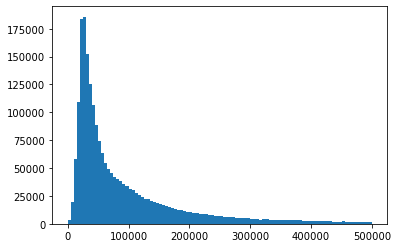

In [21]:
plt.hist(df[df['lag_time_1']<500000]['lag_time_1'],bins=100)
plt.show()

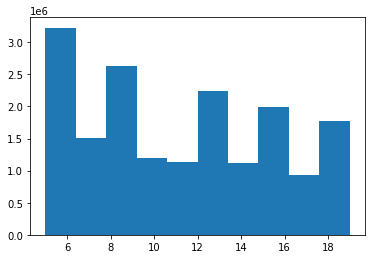

In [23]:
plt.hist(df[(df['days'] >= 5)&(df['days'] <20)]['days'],bins=10)
plt.show()

In [24]:
df[(df['days'] >= 5)&(df['days'] <20)]['days'].value_counts()

5     1646231
6     1579579
7     1511538
8     1363738
9     1262969
10    1190381
11    1134912
13    1124716
14    1116814
12    1115480
15    1020811
16     972180
17     938024
18     901137
19     866206
Name: days, dtype: int64

In [6]:
df['days'] = df['timestamp']/(1000*3600*24)
df['days'] = df['days'].astype(int)

In [16]:
df[['user_id','bundle_id','timestamp','lag_time_1','prior_question_elapsed_time','days','part','ans_user_count']][df['user_id']==5382][:50]

,user_id,bundle_id,timestamp,lag_time_1,prior_question_elapsed_time,days,part,ans_user_count
95,5382,5000,0,NaN,NaN,0,5,0.0
96,5382,3944,39828,39828.0,24000.0,0,5,1.0
97,5382,217,132189,92361.0,35000.0,0,2,2.0
98,5382,5844,153727,21538.0,88000.0,0,5,3.0
99,5382,5965,169080,15353.0,18000.0,0,5,4.0
100,5382,4990,178049,8969.0,12000.0,0,5,5.0
101,5382,5235,274437,96388.0,5000.0,0,5,6.0
102,5382,6050,348777,74340.0,92000.0,0,5,7.0
103,5382,5721,367177,18400.0,70000.0,0,5,8.0
104,5382,5580,451108,83931.0,14000.0,0,5,9.0


In [7]:
df[['user_id','timestamp','lag_time_1','lag_time_2','lag_time_3','lag_time_1_mean','lag_time_1_sum','lag_part_time_1','task_container_id','ans_user_count','timestamp','part']][20:40]

,user_id,timestamp,lag_time_1,lag_time_2,lag_time_3,lag_time_1_mean,lag_time_1_sum,lag_part_time_1,task_container_id,ans_user_count,timestamp,part
20,45001,169058,3787.0,8531.0,22115.0,8.698474e+03,165271.0,3787.0,12,20.0,169058,5
21,45001,172268,3210.0,6997.0,11741.0,8.452900e+03,169058.0,3210.0,13,21.0,172268,5
22,45001,186342,14074.0,17284.0,21071.0,8.203238e+03,172268.0,NaN,14,22.0,186342,6
23,45001,186342,14074.0,17284.0,21071.0,8.203238e+03,172268.0,NaN,14,22.0,186342,6
24,45001,186342,14074.0,17284.0,21071.0,8.203238e+03,172268.0,NaN,14,22.0,186342,6
25,45001,186342,14074.0,17284.0,21071.0,8.203238e+03,172268.0,NaN,14,22.0,186342,6
26,45001,195681,9339.0,23413.0,26623.0,7.453680e+03,186342.0,NaN,15,26.0,195681,7
27,45001,195681,9339.0,23413.0,26623.0,7.453680e+03,186342.0,NaN,15,26.0,195681,7
28,45001,195681,9339.0,23413.0,26623.0,7.453680e+03,186342.0,NaN,15,26.0,195681,7
29,45001,195681,9339.0,23413.0,26623.0,7.453680e+03,186342.0,NaN,15,26.0,195681,7


In [6]:
df

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,viretual_time_stamp,bundle_id,correct_answer,part,tags,tags1,tags2,tags3,tags4,tags5,tags6,community,part_community,ans_user_avg,ans_user_count,elapsed_time_user_avg,elapsed_time_user_sum,explanation_user_avg,first_bundle,ans_content_avg,elapsed_time_content_avg,explanation_content_avg,lag_time_1,lag_time_2,lag_time_3,lag_incorrect_time,lag_part_time_1,lag_part_time_2,lag_part_time_3,ans_user_part_avg,lag_time_1_sum,lag_time_1_mean,user_content_count,user_part_count,rolling_mean_10,rolling_mean_3,rolling_part_mean_10,rolling_part_mean_3
0,8805,0,45001,7900,0,0,3,0,NaN,0,86008635065,7900,0,1,131 93 81,131.0,93.0,81.0,NaN,NaN,NaN,2,12,NaN,0.0,NaN,NaN,NaN,7900.0,0.826225,3655.702637,0.076402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN
1,8806,21730,45001,7876,0,1,0,0,24000.0,0,86008656795,7876,3,1,10 94 92,10.0,94.0,92.0,NaN,NaN,NaN,2,12,0.000000,1.0,0.000000,0.0,0.000000,7900.0,0.418575,22636.619141,0.121566,21730.0,NaN,NaN,21730.0,21730.0,NaN,NaN,0.000000,NaN,NaN,0,1,NaN,NaN,NaN,NaN
2,8807,42763,45001,175,0,2,2,1,19000.0,0,86008677828,175,2,1,9 10 92,9.0,10.0,92.0,NaN,NaN,NaN,2,12,0.000000,2.0,12000.000000,24000.0,0.000000,7900.0,0.359887,23052.126953,0.137739,21033.0,42763.0,NaN,21033.0,21033.0,42763.0,NaN,0.000000,2.173000e+04,2.173000e+04,0,2,NaN,NaN,NaN,NaN
3,8808,61018,45001,1278,0,3,1,0,18000.0,0,86008696083,1278,3,2,143 140 81 29,143.0,140.0,81.0,29.0,NaN,NaN,2,22,0.333333,3.0,14333.333008,43000.0,0.000000,7900.0,0.649971,23277.392578,0.059241,18255.0,39288.0,61018.0,39288.0,NaN,NaN,NaN,NaN,4.276300e+04,2.138150e+04,0,0,NaN,0.333333,NaN,NaN
4,8809,102918,45001,2065,0,4,0,0,15000.0,0,86008737983,2063,2,3,136 162 92 29,136.0,162.0,92.0,29.0,NaN,NaN,2,32,0.250000,4.0,15250.000000,61000.0,0.000000,7900.0,0.634654,6907.790527,0.035685,41900.0,60155.0,81188.0,41900.0,NaN,NaN,NaN,NaN,6.101800e+04,2.033933e+04,0,0,NaN,0.333333,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2453881,101230300,1470504008,2147482216,1115,0,275,1,1,16000.0,1,82406136237,1115,1,2,155 119 162 38 102,155.0,119.0,162.0,38.0,102.0,NaN,2,22,0.637037,270.0,19440.740234,5249000.0,0.962963,3748.0,0.892542,18341.496094,0.969786,22872.0,44297.0,65700.0,230384.0,22872.0,44297.0,65700.0,0.744966,1.470481e+09,5.466472e+06,0,149,0.8,1.000000,0.9,1.0
2453882,101230301,1470528731,2147482216,1220,0,276,0,1,15000.0,1,82406160960,1220,0,2,90 100 92 102,90.0,100.0,92.0,102.0,NaN,NaN,2,22,0.638376,271.0,19428.044922,5265000.0,0.963100,3748.0,0.780375,18171.283203,0.972851,24723.0,47595.0,69020.0,255107.0,24723.0,47595.0,69020.0,0.746667,1.470504e+09,5.446311e+06,0,150,0.8,1.000000,0.9,1.0
2453883,101230302,1470551804,2147482216,869,0,277,0,1,18000.0,1,82406184033,869,0,2,62 90 100 162 29 102,62.0,90.0,100.0,162.0,29.0,102.0,2,22,0.639706,272.0,19411.765625,5280000.0,0.963235,3748.0,0.873787,18298.648438,0.974225,23073.0,47796.0,70668.0,278180.0,23073.0,47796.0,70668.0,0.748344,1.470529e+09,5.426306e+06,0,151,0.9,1.000000,0.9,1.0
2453884,101230303,1470571968,2147482216,1177,0,278,3,1,16000.0,1,82406204197,1177,3,2,143 71 81 29,143.0,71.0,81.0,29.0,NaN,NaN,2,22,0.641026,273.0,19406.593750,5298000.0,0.963370,3748.0,0.882845,18271.968750,0.977452,20164.0,43237.0,67960.0,298344.0,20164.0,43237.0,67960.0,0.750000,1.470552e+09,5.406440e+06,0,152,1.0,1.000000,0.9,1.0


In [20]:
df['user_id'].unique()

array([     45001,     176102,     238966, ..., 2147455775, 2147470777,
       2147482216])

In [6]:
base[base['timestamp']==0]['user_id'].value_counts()

169979096     5
548695005     5
1348123353    5
1389188299    5
1521955180    5
             ..
824339687     1
1898822920    1
1477977503    1
1512691377    1
1912898069    1
Name: user_id, Length: 378461, dtype: int64

In [22]:
df[df['user_id'] == 311955038][['user_id','lag_time_1','lag_time_2','lag_time_3','lag_part_time_1','task_container_id','ans_user_count','timestamp','part']][100:150]

,user_id,lag_time_1,lag_time_2,lag_time_3,lag_part_time_1,task_container_id,ans_user_count,timestamp,part
372493,311955038,128661.0,401843.0,657723.0,128661.0,2967,4269.0,14183382077,7
372494,311955038,128661.0,401843.0,657723.0,128661.0,2967,4269.0,14183382077,7
372495,311955038,148008.0,276669.0,549851.0,148008.0,2968,4271.0,14183530085,7
372496,311955038,148008.0,276669.0,549851.0,148008.0,2968,4271.0,14183530085,7
372497,311955038,148008.0,276669.0,549851.0,148008.0,2968,4271.0,14183530085,7
372498,311955038,221712.0,369720.0,498381.0,221712.0,2969,4274.0,14183751797,7
372499,311955038,221712.0,369720.0,498381.0,221712.0,2969,4274.0,14183751797,7
372500,311955038,221712.0,369720.0,498381.0,221712.0,2969,4274.0,14183751797,7
372501,311955038,7818695.0,8040407.0,8188415.0,7818695.0,2970,4277.0,14191570492,7
372502,311955038,7818695.0,8040407.0,8188415.0,7818695.0,2970,4277.0,14191570492,7


In [16]:
df['user_id'].value_counts()

119665027     7125
660727631     6290
2020092283    6188
119647028     5891
311955038     5494
              ... 
422515494        1
1027087421       1
2110023886       1
1534058183       1
1868480379       1
Name: user_id, Length: 25298, dtype: int64

In [45]:
df[df['user_id'] == 45001][['user_id','part','answered_correctly','first_bundle','ans_user_count','ans_content_avg','prior_question_elapsed_time',\
    'prior_question_elapsed_time','elapsed_time_user_sum','elapsed_time_user_avg','bundle_id']][:100]

,user_id,part,answered_correctly,first_bundle,ans_user_count,ans_content_avg,prior_question_elapsed_time,prior_question_elapsed_time,elapsed_time_user_sum,elapsed_time_user_avg,bundle_id
0,45001,1,0,7900.0,0.0,0.900000,NaN,NaN,NaN,NaN,7900
1,45001,1,0,7900.0,1.0,0.307692,24000.0,24000.0,0.0,0.000000,7876
2,45001,1,1,7900.0,2.0,0.461538,19000.0,19000.0,24000.0,12000.000000,175
3,45001,2,0,7900.0,3.0,0.777778,18000.0,18000.0,43000.0,14333.333008,1278
4,45001,3,0,7900.0,4.0,0.727273,15000.0,15000.0,61000.0,15250.000000,2063
5,45001,3,1,7900.0,4.0,0.000000,15000.0,15000.0,61000.0,15250.000000,2063
6,45001,3,0,7900.0,4.0,0.545455,15000.0,15000.0,61000.0,15250.000000,2063
7,45001,4,0,7900.0,7.0,0.444444,13000.0,13000.0,76000.0,10857.142578,3363
8,45001,4,0,7900.0,7.0,0.222222,13000.0,13000.0,76000.0,10857.142578,3363
9,45001,4,0,7900.0,7.0,0.111111,13000.0,13000.0,76000.0,10857.142578,3363


In [32]:
df['user_id'][:10000].unique()[:20]

array([  45001,  176102,  238966,  260489,  357865,  364452,  459017,
        592864,  616513,  653826,  702591, 1024273, 1108398, 1186307,
       1298591, 1321608, 1547989, 1647850, 1857371, 1960671])

In [37]:
df[df['user_id'] == 45001]['task_container_id'].value_counts()

15    4
14    4
7     3
6     3
5     3
4     3
13    1
12    1
11    1
10    1
9     1
8     1
3     1
2     1
1     1
0     1
Name: task_container_id, dtype: int64

In [21]:
df[['user_id','bundle_id','content_id','timestamp','lag_time_1','lag_time_2','lag_time_3','elapsed_time_user_sum','ans_user_count','user_content_count']].iloc[260:280]

,user_id,bundle_id,content_id,timestamp,lag_time_1,lag_time_2,lag_time_3,elapsed_time_user_sum,ans_user_count,user_content_count
260,8623,10688,10688,172041830,47966.0,110165.0,155028.0,846000.0,40.0,0.0
261,8623,675,675,172087052,45222.0,93188.0,155387.0,862000.0,41.0,1.0
262,8623,651,651,172110923,23871.0,69093.0,117059.0,880000.0,42.0,1.0
263,8623,7744,7747,320281387,148170464.0,148194336.0,148239552.0,897000.0,43.0,0.0
264,8623,7744,7748,320281387,148170464.0,148194336.0,148239552.0,914000.0,43.0,0.0
265,8623,7744,7745,320281387,148170464.0,148194336.0,148239552.0,931000.0,43.0,0.0
266,8623,7744,7744,320281387,148170464.0,148194336.0,148239552.0,948000.0,43.0,0.0
267,8623,7744,7746,320281387,148170464.0,148194336.0,148239552.0,965000.0,43.0,0.0
268,8623,7190,7193,331424277,11142890.0,159313360.0,159337232.0,982000.0,48.0,0.0
269,8623,7190,7190,331424277,11142890.0,159313360.0,159337232.0,1059000.0,48.0,0.0


In [15]:
a = [1,2,3]
for i,j in enumerate(a):
    i,j

In [16]:
i

2